In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Dataset paths
dataset_dir = r"C:\Users\Vansh Payala\Downloads\archive (13)\raw-img"
train_dir = r"C:\Users\Vansh Payala\Downloads\train"
val_dir = r"C:\Users\Vansh Payala\Downloads\val"
test_dir = r"C:\Users\Vansh Payala\Downloads\test"

In [2]:
# Parameters
IMAGE_SIZE = (224, 224)  # VGG16 input size
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001
CLASSES = 10  # Number of animal classes

In [3]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 13278 images belonging to 10 classes.
Found 2618 images belonging to 10 classes.


In [ ]:
# Pre-trained VGG16 Model without the top (classification) layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freezing the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(CLASSES, activation='softmax')(x)

# Building the final model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Evaluating on test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

Epoch 1/15
415/415 [==============================] - 3934s 9s/step - loss: 1.2818 - accuracy: 0.5712 - val_loss: 0.7200 - val_accuracy: 0.7788
Epoch 2/15
415/415 [==============================] - 3774s 9s/step - loss: 0.9232 - accuracy: 0.6893 - val_loss: 0.6151 - val_accuracy: 0.8002
Epoch 3/15
415/415 [==============================] - 3136s 8s/step - loss: 0.8392 - accuracy: 0.7154 - val_loss: 0.5760 - val_accuracy: 0.8079
Epoch 4/15
415/415 [==============================] - 3053s 7s/step - loss: 0.7734 - accuracy: 0.7373 - val_loss: 0.5181 - val_accuracy: 0.8273
Epoch 5/15
415/415 [==============================] - 3032s 7s/step - loss: 0.7250 - accuracy: 0.7538 - val_loss: 0.5004 - val_accuracy: 0.8319
Epoch 6/15
415/415 [==============================] - 3021s 7s/step - loss: 0.7028 - accuracy: 0.7615 - val_loss: 0.4879 - val_accuracy: 0.8430
Epoch 7/15
415/415 [==============================] - 3020s 7s/step - loss: 0.6810 - accuracy: 0.7708 - val_loss: 0.5271 - val_accuracy:

Classification Report:
              precision    recall  f1-score   support

        cane       0.90      0.83      0.86       487
     cavallo       0.82      0.92      0.87       263
    elefante       0.82      0.89      0.85       145
    farfalla       0.90      0.90      0.90       212
     gallina       0.83      0.93      0.88       310
       gatto       0.90      0.81      0.85       167
       mucca       0.86      0.73      0.79       187
      pecora       0.76      0.79      0.78       182
       ragno       0.93      0.95      0.94       483
  scoiattolo       0.84      0.78      0.81       187

    accuracy                           0.87      2623
   macro avg       0.86      0.85      0.85      2623
weighted avg       0.87      0.87      0.87      2623



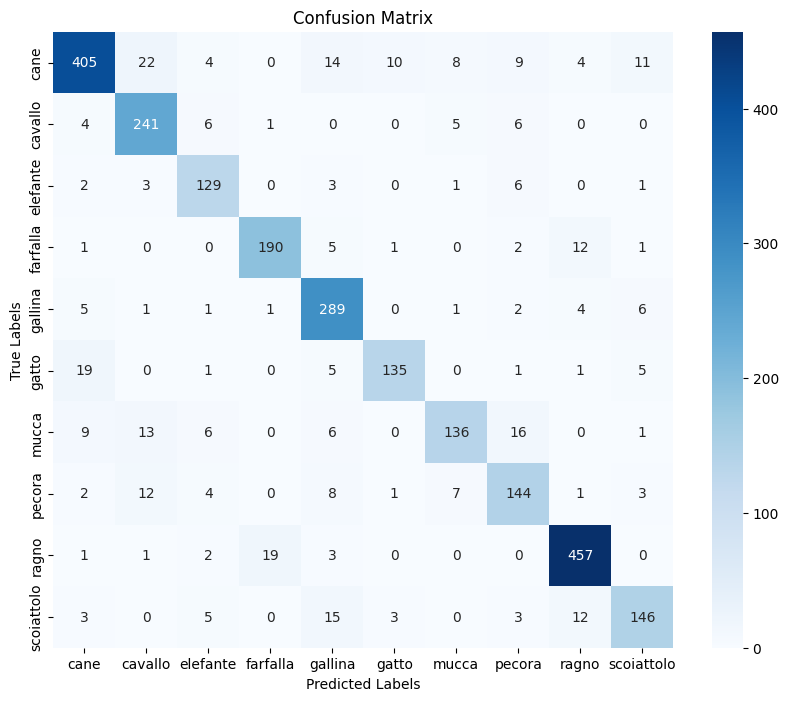

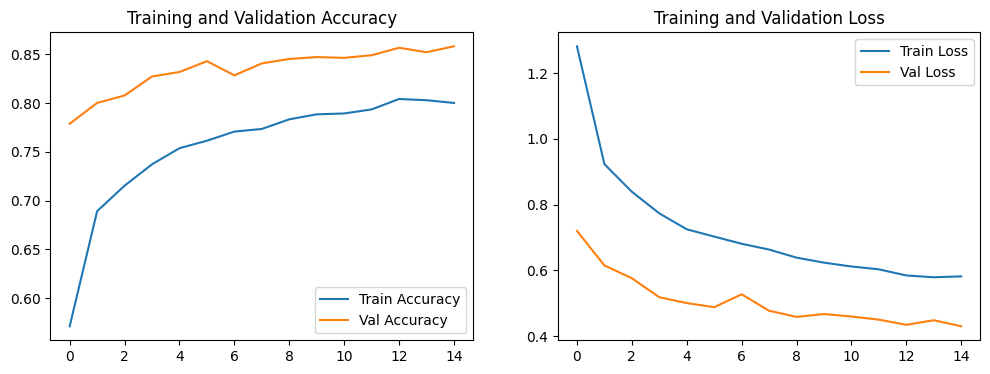

In [ ]:
# Classification Report and Confusion Matrix

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Plotting Training and Validation Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()